In [68]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [69]:
data = pd.read_excel("/content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


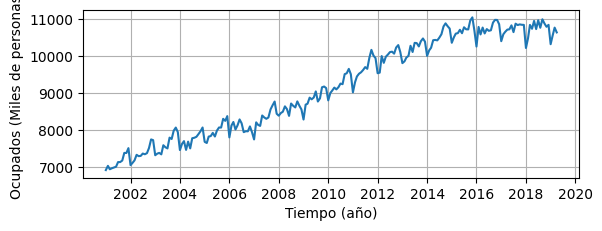

In [70]:
plt.subplot(2,1, 2)
plt.title("")
plt.xlabel("Tiempo (año)")
plt.ylabel("Ocupados (Miles de personas)")
plt.plot(data[["Ocupados"]])
plt.grid()

plt.show()

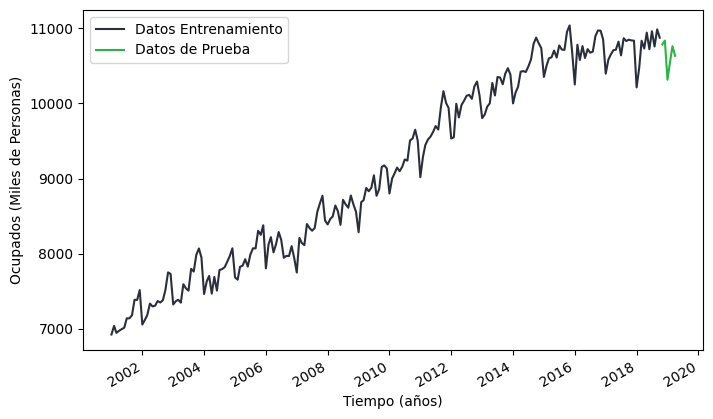

In [72]:

train_len = 214
train_oc = data[["Ocupados"]][:train_len]
test_oc = data[["Ocupados"]][train_len:]


fig = plt.figure(figsize=(8, 5))
plt.plot(train_oc,label="Datos Entrenamiento", color='#2B2E3B')
plt.plot(test_oc,label="Datos de Prueba", color='#27B641')
fig.autofmt_xdate()
plt.ylabel("Ocupados (Miles de Personas)")
plt.xlabel("Tiempo (años)")

plt.legend()
plt.savefig('general.png', dpi=300, transparent=True)

plt.show()


In [41]:
train_oc

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782


In [42]:
y = train_oc["Ocupados"]
x = np.linspace(1,train_oc.shape[0],train_oc.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     5439.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          4.10e-153
Time:                        15:51:11   Log-Likelihood:                -1483.6
No. Observations:                 214   AIC:                             2971.
Df Residuals:                     212   BIC:                             2978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6916.5808     34.202    202.227      0.0

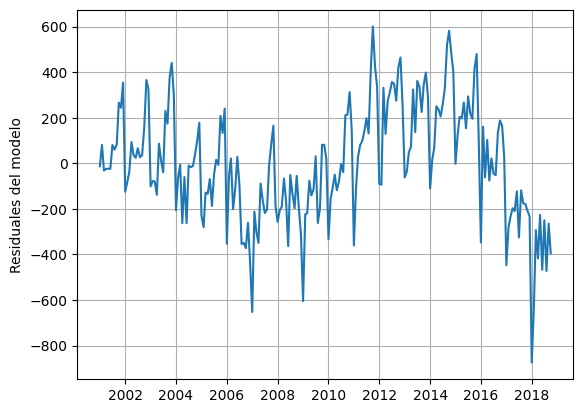

In [43]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

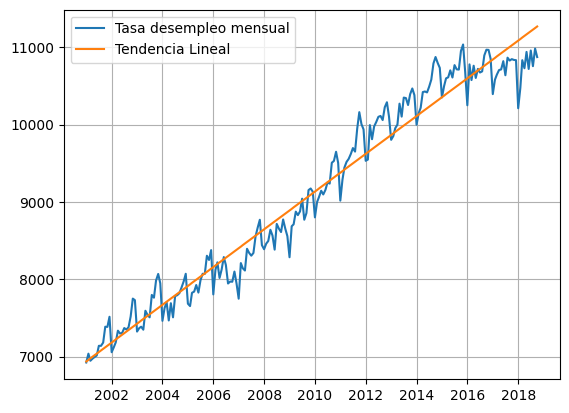

In [44]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [45]:
h=6
x_for= np.linspace((train_oc.shape[0]+1),(train_oc.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [46]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11290.562073  10794.552484  11786.571663
1    11310.906172  10814.832205  11806.980139
2    11331.250271  10835.111339  11827.389204
3    11351.594370  10855.389885  11847.798855
4    11371.938469  10875.667843  11868.209094
5    11392.282568  10895.945215  11888.619920


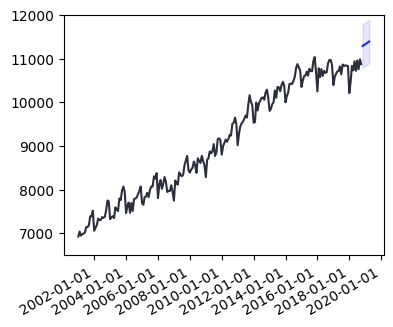

In [47]:
import matplotlib.dates as mdates

range_dates = pd.date_range(train_oc.index[-1] + relativedelta(months=1), periods=h, freq='MS')
fig = plt.figure(figsize=(8, 6))  # Tamaño más pequeño
ax = fig.add_axes([0.55, 0.15, 0.4, 0.4])  # [left, bottom, width, height]

# Plot the data
ax.plot(train_oc.index, y, label="Datos Entrenamiento", color='#2B2E3B')
ax.plot(range_dates, preds['Point_forecast'], label="Predicciones", color='#0D2FD8')
ax.fill_between(range_dates, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
ax.set_ylim(6500, 12000)
# Set date formatting
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.savefig('f_1.png', dpi=300, transparent=True)

# Display the legend and the plot
plt.show()


In [48]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

x_test = np.linspace(train_len + 1, train_len + test_oc.shape[0], test_oc.shape[0])
X_test = sm.add_constant(x_test)

preds = lin_t.predict(X_test)
# Calculate Mean Squared Error between predicted and actual values in the test dataset
mse = mean_squared_error(test_oc, preds)
rmse = np.sqrt(mse)
print(rmse)

718.651675100181


Cuadratica

In [49]:

y = train_oc["Ocupados"]
train_oc["x"] = np.linspace(1,train_oc.shape[0],train_oc.shape[0])
train_oc["x2"] = x**2
X = sm.add_constant(train_oc[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2750.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          7.46e-152
Time:                        15:51:12   Log-Likelihood:                -1482.0
No. Observations:                 214   AIC:                             2970.
Df Residuals:                     211   BIC:                             2980.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6846.9680     51.330    133.392      0.0

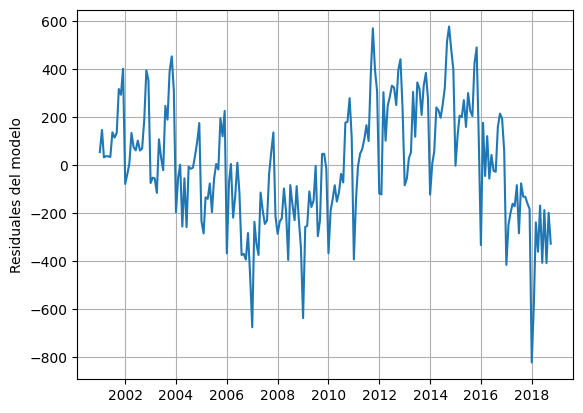

In [50]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

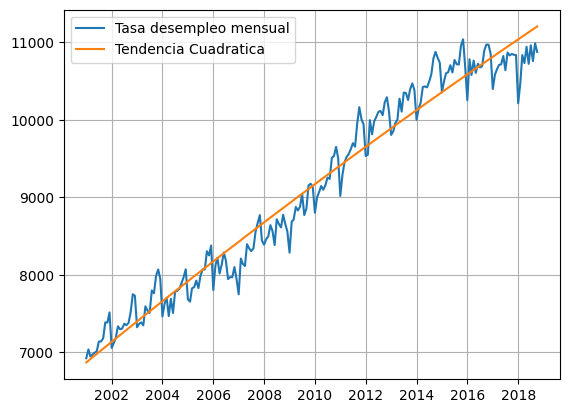

In [51]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [52]:
h=6
x_for= np.linspace((train_oc.shape[0]+1),(train_oc.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [53]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11220.949257  10721.787967  11720.110547
1    11239.350672  10739.800787  11738.900558
2    11257.734100  10757.783260  11757.684941
3    11276.099540  10775.735164  11776.463916
4    11294.446992  10793.656279  11795.237705
5    11312.776457  10811.546382  11814.006531


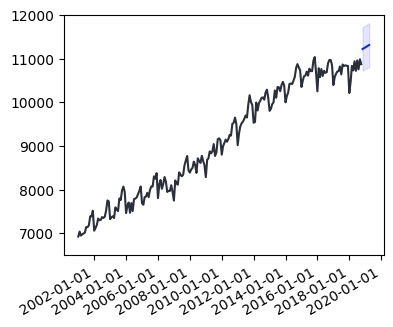

In [54]:
fig = plt.figure(figsize=(8, 6))  # Tamaño más pequeño
ax = fig.add_axes([0.55, 0.15, 0.4, 0.4])  # [left, bottom, width, height]

# Plot the data
ax.plot(train_oc.index, y, label="Datos Entrenamiento", color='#2B2E3B')
ax.plot(range_dates, preds['Point_forecast'], label="Predicciones", color='#0D2FD8')
ax.fill_between(range_dates, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
ax.set_ylim(6500, 12000)
# Set date formatting
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.savefig('f_2.png', dpi=300, transparent=True)
# Display the plot
plt.show()

In [55]:
# Crear un rango para las predicciones en el conjunto de prueba usando un modelo cuadrático
x_test = np.linspace(train_len + 1, train_len + test_oc.shape[0], test_oc.shape[0])
X_test_quad = sm.add_constant(np.stack((x_test, x_test**2), axis=1))

# Hacer predicciones usando el modelo cuadrático ajustado
preds_quad = pol_2.predict(X_test_quad)

# Calcular el Error Cuadrático Medio entre las predicciones y los valores reales en el conjunto de prueba
mse_quad = mean_squared_error(test_oc["Ocupados"], preds_quad)
rmse_quad = np.sqrt(mse_quad)

print(f"Root Mean Squared Error for Quadratic Model: {rmse_quad:.2f}")

Root Mean Squared Error for Quadratic Model: 646.60


A la 3

In [56]:
train_oc["x"] = np.linspace(1, train_oc.shape[0], train_oc.shape[0])
train_oc["x2"] = train_oc["x"]**2
train_oc["x3"] = train_oc["x"]**3


X = sm.add_constant(train_oc[["x", "x2", "x3"]])  # Use the constant and the x and x4 terms for regression
pol = sm.OLS(y, X)
pol_3 = pol.fit()  # Renaming it to pol_4 to remind us it's a 4th degree polynomial model
print(pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2873.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          3.73e-170
Time:                        15:51:17   Log-Likelihood:                -1434.9
No. Observations:                 214   AIC:                             2878.
Df Residuals:                     210   BIC:                             2891.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7246.7790     55.503    130.565      0.0

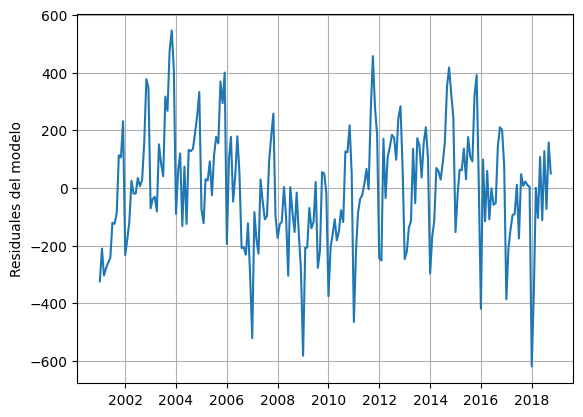

In [57]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_3.resid)
plt.grid()

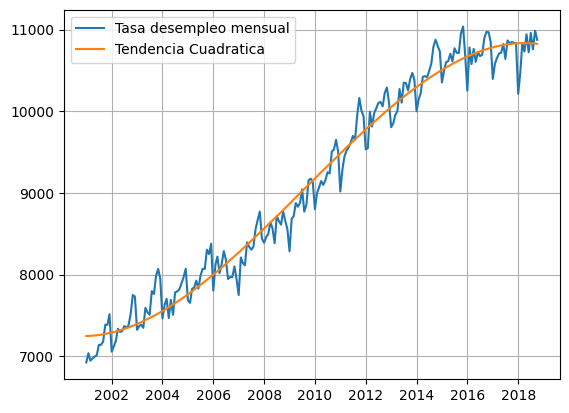

In [58]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_3.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [59]:
# Predicciones
h = 6
x_for = np.linspace(train_oc.shape[0] + 1, train_oc.shape[0] + h, h)
X_for = sm.add_constant(np.column_stack((x_for, x_for**2, x_for**3)))

dt = pol_3.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    10821.138290  10413.038112  11229.238468
1    10817.224675  10408.066442  11226.382908
2    10812.776520  10402.493637  11223.059404
3    10807.789065  10396.312228  11219.265902
4    10802.257549  10389.514708  11215.000391
5    10796.177211  10382.093533  11210.260890


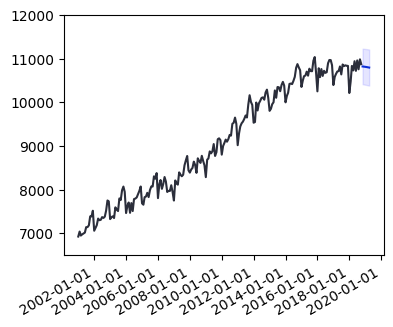

In [60]:
# Create a figure and axis with specified dimensions
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.55, 0.15, 0.4, 0.4])


ax.plot(train_oc.index, y, color='#2B2E3B')
ax.plot(range_dates, preds['Point_forecast'], color='#0D2FD8')
ax.fill_between(range_dates, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
ax.set_ylim(6500, 12000)
# S
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.savefig('f_3.png', dpi=300, transparent=True)
# Displaying the plot
plt.show()

In [61]:
x_test = np.linspace(train_len + 1, train_len + test_oc.shape[0], test_oc.shape[0])
X_test_cubic = sm.add_constant(np.column_stack((x_test, x_test**2, x_test**3)))
preds_cubic = pol_3.predict(X_test_cubic)
mse_cubic = mean_squared_error(test_oc["Ocupados"], preds_cubic)
rmse_cubic = np.sqrt(mse_cubic)
print(f"Root Mean Squared Error for Cubic Model: {rmse_cubic:.2f}")

Root Mean Squared Error for Cubic Model: 238.47


Estimación de la Estacionalidad

In [62]:
month_dummies = pd.get_dummies(train_oc.index.month, drop_first=True).set_index(train_oc.index)


train_oc["x"] = np.linspace(1, train_oc.shape[0], train_oc.shape[0])
train_oc["x2"] = train_oc["x"]**2
train_oc["x3"] = train_oc["x"]**3
X = sm.add_constant( pd.concat([train_oc[["x","x2", "x3"]],month_dummies],axis=1) )

season_pol3 = sm.OLS(y,X)
season_pol_3 = season_pol3.fit()
print(season_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1079.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          3.41e-179
Time:                        15:51:59   Log-Likelihood:                -1370.3
No. Observations:                 214   AIC:                             2771.
Df Residuals:                     199   BIC:                             2821.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6975.3189     53.370    130.698      0.0

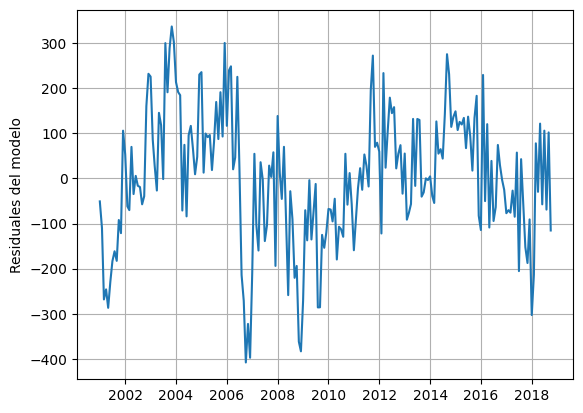

In [63]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_3.resid)
plt.grid()

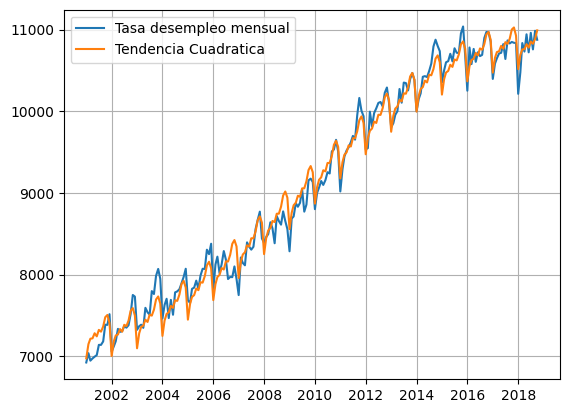

In [64]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(season_pol_3.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [65]:
h=6
x_for= np.linspace((train_oc.shape[0]+1),(train_oc.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2, x_for**3),axis=1),columns=["x","x2", "x3"] )

range_dates = pd.date_range(train_oc.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month).reindex(columns=range(2, 13), fill_value=0)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for
dt = season_pol_3.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2018-11-01    11008.558011  10690.367492  11326.748530
2018-12-01    10902.425453  10583.545307  11221.305600
2019-01-01    10486.540957  10166.983210  10806.098703
2019-02-01    10654.243700  10333.916199  10974.571202
2019-03-01    10714.046335  10392.905584  11035.187086
2019-04-01    10711.070028  10389.070892  11033.069165


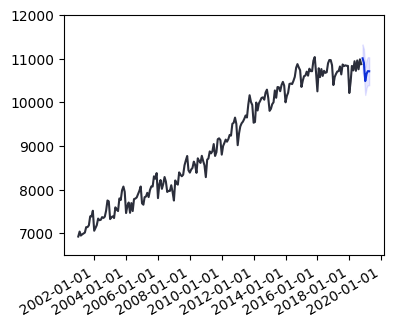

In [67]:

# Create a figure and axis with specified dimensions
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.55, 0.15, 0.4, 0.4])


ax.plot(train_oc.index, y, color='#2B2E3B')
ax.plot(range_dates, preds['Point_forecast'], color='#0D2FD8')
ax.fill_between(range_dates, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
ax.set_ylim(6500, 12000)
# S
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()


plt.savefig('f_4.png', dpi=300, transparent=True)
# Displaying the plot
plt.show()

In [ ]:
# Generar las variables independientes para este caso (ojo)
x_test = np.linspace(train_oc.shape[0] + 1, train_oc.shape[0] + test_oc.shape[0], test_oc.shape[0])
test_month_dummies = pd.get_dummies(test_oc.index.month).reindex(columns=range(2, 13), fill_value=0).set_index(test_oc.index)
X_test_season_poly = sm.add_constant(pd.concat([pd.DataFrame({'x': x_test, 'x2': x_test**2, 'x3': x_test**3}, index=test_oc.index), test_month_dummies], axis=1))

# Predecir usando el modelo season_pol_3
preds_season_test = season_pol_3.predict(X_test_season_poly)

mse_season = mean_squared_error(test_oc["Ocupados"], preds_season_test)
rmse_season = np.sqrt(mse_season)
print(f"Root Mean Squared Error for Cubic Model with Seasonality: {rmse_season:.2f}")

Root Mean Squared Error for Cubic Model with Seasonality: 130.74
